In [1]:
import torch
import torch.nn.functional as F
import gc
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from supervoice_enhance.model import EnhanceModel 
from supervoice_enhance.audio import load_mono_audio, spectogram
from supervoice_enhance.config import config
from training.effects import default_noisy_pipeline

In [2]:
# Distortion Pipeline
rir_files = []
with open('./external_datasets/rir-1/files.txt', 'r') as file:
    for line in file:
        rir_files.append("./external_datasets/rir-1/" + line.strip())
bg_files = []
for p in Path("./external_datasets/dns-noise").rglob("*.wav"):
    bg_files.append(str(p))
pipeline = default_noisy_pipeline(rirs = rir_files, bg = bg_files)

# Model
device = "cuda:1"
vocoder = torch.hub.load(repo_or_dir='ex3ndr/supervoice-vocoder', model='bigvsan')
flow = torch.hub.load(repo_or_dir='ex3ndr/supervoice-flow', model='flow')
checkpoint = torch.load(f'./output/ft-07.pt', map_location="cpu")
enhance = EnhanceModel(flow, config)
enhance.load_state_dict(checkpoint['model'])
enhance.to(device)
enhance.eval()
vocoder.to(device)
vocoder.eval()
print("OK")

Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-vocoder_master
Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-flow_main


OK


In [3]:
def do_vocoder(src):
    with torch.no_grad():
        return vocoder.generate(src)

def do_enhance(src, steps = 8):
    with torch.no_grad():
        src = (src - config.audio.norm_mean) / config.audio.norm_std
        pr = enhance.sample(source = src.to(torch.float32), steps = steps)
        return ((pr * config.audio.norm_std) + config.audio.norm_mean).to(torch.float32)

def do_flow(src, steps = 8):
    with torch.no_grad():
        src = (src - config.audio.norm_mean) / config.audio.norm_std
        pr, _ = direct_flow.sample(audio = src.to(torch.float32), steps = steps)
        return ((pr * config.audio.norm_std) + config.audio.norm_mean).to(torch.float32)

def do_distort(src):
    return pipeline.apply(src, config.audio.sample_rate)

In [15]:
# Load source file
# source_file = "./DNS-Challenge/datasets_fullband/datasets_fullband/clean_fullband/emotional_speech/1002_ITH_SAD_XX.wav"
source_file = "./external_datasets/libritts-r/test-other/6128/63244/6128_63244_000000_000000.wav"
# source_file = "./external_datasets/dns/noisy_testclips/ms_pns_DellPrecision7510_A1N8TKTLXV92QR_Baby_Crying_primarywithnoise_fileid_1.wav"
source_raw = load_mono_audio(source_file, sample_rate = config.audio.sample_rate)
target_length = 5 * config.audio.sample_rate
current_length = source_raw.shape[0]
padding_length = target_length - current_length
source_raw = F.pad(source_raw, (0, padding_length), mode='constant')

# Distort audio
distorted = do_distort(source_raw)

# Get spectogram
spec = spectogram(distorted, 
    n_fft = config.audio.n_fft, 
    n_mels = config.audio.n_mels, 
    n_hop = config.audio.hop_size, 
    n_window = config.audio.win_size,  
    mel_norm = config.audio.mel_norm, 
    mel_scale = config.audio.mel_scale, 
    sample_rate = config.audio.sample_rate
)
spec_raw = spectogram(source_raw, 
    n_fft = config.audio.n_fft, 
    n_mels = config.audio.n_mels, 
    n_hop = config.audio.hop_size, 
    n_window = config.audio.win_size,  
    mel_norm = config.audio.mel_norm, 
    mel_scale = config.audio.mel_scale, 
    sample_rate = config.audio.sample_rate
)

# Vocode back
source_rec = do_vocoder(spec.to(device).unsqueeze(0)).squeeze(0)
display(Audio(data=source_raw.cpu(), rate=config.audio.sample_rate))
display(Audio(data=source_rec.cpu(), rate=config.audio.sample_rate))

In [17]:
enhanced = do_enhance(spec.to(device).transpose(0, 1), 32)
enhanced_2 = do_enhance(enhanced.to(device), 32)
enhanced_rec = do_vocoder(enhanced.transpose(0, 1).to(device).unsqueeze(0)).squeeze(0)
enhanced_rec_2 = do_vocoder(enhanced_2.transpose(0, 1).to(device).unsqueeze(0)).squeeze(0)
display(Audio(data=enhanced_rec.cpu(), rate=config.audio.sample_rate))
display(Audio(data=enhanced_rec_2.cpu(), rate=config.audio.sample_rate))

In [16]:
enhanced_raw = spec_raw.to(device).transpose(0, 1)
for i in range(1):
    enhanced_raw = do_enhance(enhanced_raw, 8)
enhanced_raw_rec = do_vocoder(enhanced_raw.transpose(0, 1).to(device).unsqueeze(0)).squeeze(0)
display(Audio(data=enhanced_raw_rec.cpu(), rate=config.audio.sample_rate))

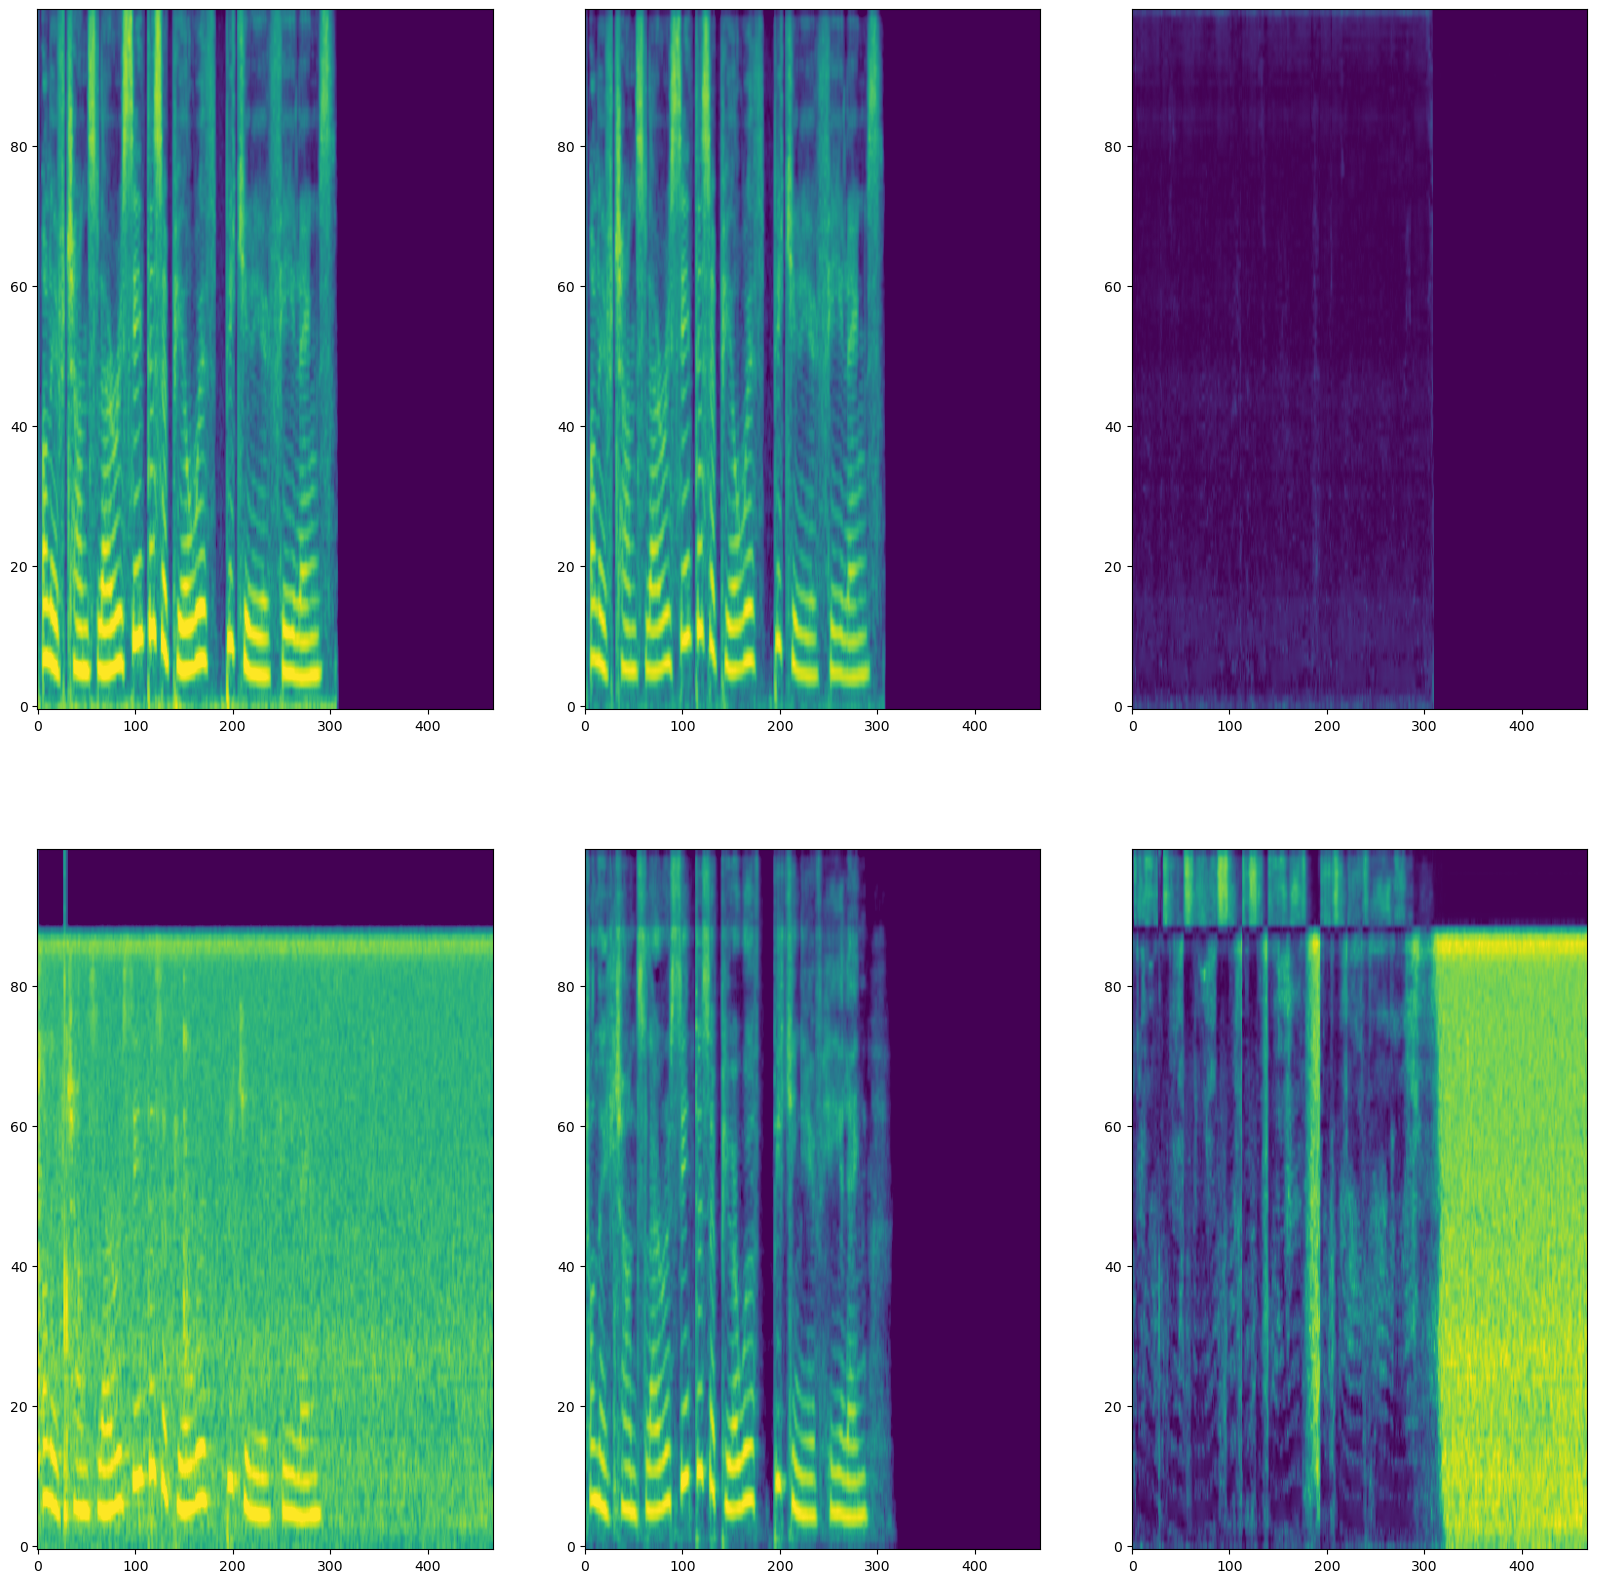

In [12]:
_, ax = plt.subplots(2, 3, figsize=(20, 20))
ax[0][0].imshow(spec_raw, vmin=-10, vmax=0, origin="lower", aspect="auto") # Original
ax[0][1].imshow(enhanced_raw.cpu().squeeze(0).T, vmin=-10, vmax=0, origin="lower", aspect="auto") # Enhanced Original  
ax[0][2].imshow((spec_raw - enhanced_raw.cpu().squeeze(0).T).abs(), vmin=0, vmax=10, origin="lower", aspect="auto")
ax[1][0].imshow(spec, vmin=-10, vmax=0, origin="lower", aspect="auto") # Distorted
ax[1][1].imshow(enhanced.cpu().squeeze(0).T, vmin=-10, vmax=0, origin="lower", aspect="auto") # Enhanced
ax[1][2].imshow((spec - enhanced.cpu().squeeze(0).T).abs(), vmin=0, vmax=10, origin="lower", aspect="auto")